# Generating names with recurrent neural networks

In this programming assignment you'll find yourself delving into the heart (and other intestines) of recurrent neural networks on a class of toy problems.

Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train RNN instead.

In [1]:
%%bash

shred -u setup_colab.py

wget https://raw.githubusercontent.com/hse-aml/intro-to-dl-pytorch/main/utils/setup_colab.py -O setup_colab.py

--2021-06-09 15:31:20--  https://raw.githubusercontent.com/hse-aml/intro-to-dl-pytorch/main/utils/setup_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1649 (1,6K) [text/plain]
Saving to: ‘setup_colab.py’

     0K .                                                     100% 1,66M=0,001s

2021-06-09 15:31:21 (1,66 MB/s) - ‘setup_colab.py’ saved [1649/1649]



In [2]:
import setup_colab

setup_colab.setup_week05()

In [3]:
import numpy as np
import matplotlib.pyplot as plt

### Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email.

In [4]:
import grading

grader = grading.Grader(
    assignment_key="cULEpp2NEeemQBKZKgu93A",
    all_parts=["pttMO", "uly0D", "mf20L", "zwTu9"]
)

In [5]:
# token expires every 30 min
COURSERA_TOKEN = "### YOUR TOKEN HERE ###"
COURSERA_EMAIL = "### YOUR EMAIL HERE ###"

# Load data
The dataset contains ~8k names from different cultures, all in latin transcript.

This notebook has been designed so as to allow you to quickly swap names for something similar: deep learning article titles, IKEA furniture, pokemon names, etc.

In [6]:
start_token = " "  # so that the network knows that we're generating a first token

# this is the token for padding,
# we will add fake pad token at the end of names 
# to make them of equal size for further batching
pad_token = "#"

with open("names.txt") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token + name for name in names]

In [7]:
print('number of samples:', len(names))
for x in names[::1000]:
    print(x)
    
names[::1000];

number of samples: 7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


max length: 16


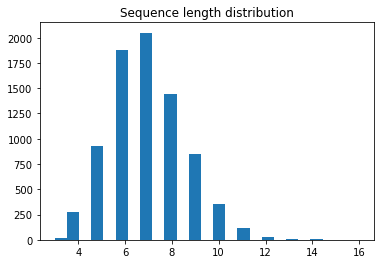

In [8]:
MAX_LENGTH = max(map(len, names))
print("max length:", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)), bins=25);

# Text processing

First we need to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [9]:
### YOUR CODE HERE: all unique characters in the dataset ###
tokens = set(''.join(names))
tokens.add(pad_token) # adding pad_token
print(list(tokens))

num_tokens = len(tokens)
print ('\nnum_tokens = ', num_tokens)

assert 50 < num_tokens < 60, "Names should contain within 50 and 60 unique tokens depending on encoding"

['Z', 'a', 'm', 'y', 'p', 'C', 'b', 'L', 'c', 'j', 'G', 'g', 'I', 'r', 'P', 'F', 'l', ' ', 'J', 'v', 'h', 'w', 'u', 'o', 'Y', '#', 'O', 'A', 'q', 'i', 'e', 'n', '-', 'B', 'N', 'U', 'f', 's', 'k', 'S', 'T', 'x', 'H', 'R', 'd', 'D', "'", 't', 'V', 'z', 'X', 'Q', 'E', 'K', 'M', 'W']

num_tokens =  56


### Cast everything from symbols into identifiers

Instead of symbols we'll feed our recurrent neural network with ids of characters from our dictionary.

To create such dictionary, let's assign `token_to_id`

In [10]:
### YOUR CODE HERE: create a dictionary of {symbol -> its  index in tokens}
token_to_id = {t: i for i,t in enumerate(tokens)}
print(token_to_id)
# notice the special characters along the way

assert len(tokens) == len(token_to_id), "dictionaries must have same size"

{'Z': 0, 'a': 1, 'm': 2, 'y': 3, 'p': 4, 'C': 5, 'b': 6, 'L': 7, 'c': 8, 'j': 9, 'G': 10, 'g': 11, 'I': 12, 'r': 13, 'P': 14, 'F': 15, 'l': 16, ' ': 17, 'J': 18, 'v': 19, 'h': 20, 'w': 21, 'u': 22, 'o': 23, 'Y': 24, '#': 25, 'O': 26, 'A': 27, 'q': 28, 'i': 29, 'e': 30, 'n': 31, '-': 32, 'B': 33, 'N': 34, 'U': 35, 'f': 36, 's': 37, 'k': 38, 'S': 39, 'T': 40, 'x': 41, 'H': 42, 'R': 43, 'd': 44, 'D': 45, "'": 46, 't': 47, 'V': 48, 'z': 49, 'X': 50, 'Q': 51, 'E': 52, 'K': 53, 'M': 54, 'W': 55}


In [11]:
def to_matrix(lines, max_len=None, pad=token_to_id[pad_token], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad # make sure it is padded

    for i in range(len(lines)):
        line_ix = [token_to_id[c] for c in lines[i]]
        lines_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        lines_ix = np.transpose(lines_ix)

    return lines_ix

In [12]:
# Example: cast 4 random names to padded matrices (so that we can easily batch them)
print('\n'.join(names[::2000]))
print('\n', to_matrix(names[::2000]))

 Abagael
 Glory
 Prissie
 Giovanne

 [[17 27  6  1 11  1 30 16 25]
 [17 10 16 23 13  3 25 25 25]
 [17 14 13 29 37 37 29 30 25]
 [17 10 29 23 19  1 31 31 30]]


# Defining a recurrent neural network

We can rewrite recurrent neural network as a consecutive application of dense layer to input $x_t$ and previous rnn state $h_t$. This is exactly what we're gonna do now.
<img src="images/rnn.png" width=600>

Since we're training a language model, there should also be:
* An embedding layer that converts character id x_t to a vector.
* An output layer that predicts probabilities of next phoneme based on h_t+1

In [13]:
import os

import torch, torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # you can change to `cuda`

# os.path('./')

In [14]:
class CharRNNCell(pl.LightningModule):
    """
    Implement the scheme above as torch module
    """
    
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super().__init__()
        self.num_units = rnn_num_units
        self.num_tokens = num_tokens
        self.embedding_size = embedding_size
        self.rnn_num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, int64[batch_size]
        :param h_prev: previous rnn hidden states, float32 matrix [batch, rnn_num_units]
        """
        # get vector embedding of x 
        ### YOUR CODE HERE ###
        # x: torch.Size([batch])
        x_emb = self.embedding(x) # torch.Size([batch, embedding_size])
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation 
        ### YOUR CODE HERE ###
        
        # h_prev.shape: torch.Size([batch, rnn_num_units])
        emb_rnn = torch.cat((x_emb, h_prev), 1) # torch.Size([batch, embedding_size + rnn_num_units])
        h_next = self.rnn_update(emb_rnn)
        
        assert h_next.size() == h_prev.size() # torch.Size([batch, rnn_num_units])
        
        #compute logits for next character probs 
        ### YOUR CODE HERE ###
        logits = self.rnn_to_logits(h_prev) # torch.Size([batch, rnn_num_units])
        
        return h_next, logits
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units)
    
    
    
    def general_step(self, batch, batch_idx, mode):
        # batch: data, label, lengths
        data = batch['data']
        label = batch['label']
        lengths = batch['lengths']

        out = self.forward(data)

        loss_fn = nn.BCELoss(reduction='mean')
        loss = loss_fn(out, label)
        return loss

    def general_end(self, outputs, mode):
        avg_loss = torch.stack([x[mode+'_loss'] for x in outputs]).mean()
        return avg_loss

    def training_step(self, batch, batch_idx):
        loss = self.general_step(batch, batch_idx, 'train')
        return {'loss': loss}

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters())
        return optim


# RNN: loop

Once `rnn_one_step` is ready, let's apply it in a loop over name characters to get predictions -- we will generate names character by character starting with start_token:

<img src="images/char-nn.png" width=600>

In [15]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes logits_seq(next_character) for all time-steps in batch_ix
    :param batch_ix: an int32 matrix of shape [batch, time], output of to_matrix(lines)
    """
    batch_ix.to(DEVICE)
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size).to(DEVICE)
    logits_seq = []
    
    for x_t in batch_ix.transpose(0,1):
        hid_state, logits = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logits_seq.append(logits)
    
    # logits_seq[0].shape: torch.Size([batch_size, logits_seq])
    return torch.stack(logits_seq, dim=1) # torch.Size([batch_size=5, max_len=8, len_tokens:56])

Check that the output of rnn_loop has the right format:

In [16]:
batch_ix = to_matrix(names[:5])
batch_ix = torch.tensor(batch_ix, device=DEVICE, dtype=torch.int64) # torch.Size({batch_size, max_len})

logits_seq = rnn_loop(CharRNNCell().to(DEVICE), batch_ix)

In [17]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("mf20L", tuple(logits_seq.size()))

## Training
We train our char-rnn exactly the same way we train any deep learning model, the only difference is that this time we sample strings. 

To compute the loss in a vectorized manner, we can take `batch_ix[:, 1:]` -- a matrix of token ids shifted 1 step to the left so i-th element is acutally the "next token" for i-th prediction. 

In [18]:
from IPython.display import clear_output
from random import sample

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # you can change to `cuda`

char_rnn = CharRNNCell().to(DEVICE)

opt = torch.optim.Adam(char_rnn.parameters())
criterion = nn.CrossEntropyLoss()
history = []

In [20]:
for i in range(1000):
    # for simplisity we will 
    batch_ix = to_matrix(sample(names, 32))
    batch_ix = torch.tensor(batch_ix, device=DEVICE, dtype=torch.int64) #torch.Size([batch_size, max_len])

    # clear gradients
    opt.zero_grad()
    
    # do forward pass
    logits_seq = rnn_loop(char_rnn, batch_ix).to(DEVICE)# torch.Size([batch_size, max_len, logits_seq])
    
    # make shifted versions of batch and predictions to compute the loss 
    predictions_logits = logits_seq.moveaxis(-1, 1)
    actual_next_tokens = batch_ix    
    
    # compute loss ### YOUR CODE HERE ###
    loss = criterion(predictions_logits, actual_next_tokens)
    history.append(loss.item())
    
    # train with backprop ### YOUR CODE HERE ###
    loss.backward()
    opt.step()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

predictions_logits:  torch.Size([32, 56, 10])
predictions_logits:  torch.Size([32, 56, 10])
actual_next_tokens:  torch.Size([32, 10])


In [20]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("zwTu9", int(np.mean(history[:10]) > np.mean(history[-10:])))

Here we computed loss over all symbols including pad tokens at the end of each name. In practice it would be better to exclude all pad tokens except one for each sequence. We need our model to be able to generate one pad token at the end of the sequence to mark the end of the sequence, but there is no need to generate all next pad tokens (we use them just for 
convenient data representation). 

Parameter ignore_index of CrossEntropyLoss allows to do so.



## RNN: sampling
Once we've trained our network a bit, let's get to actually generating stuff. All we need is the single rnn step function you have defined in char_rnn.forward.

In [21]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a start phrase.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  Higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        char_rnn.to('cpu')
        hid_state, logits_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
    
    return ''.join([list(tokens)[ix] for ix in x_sequence.data.numpy()[0]])

In [22]:
for _ in range(10):
    print(generate_sample(char_rnn))

 aMraeela#r#####
  Pirtain#e#####
 HBoent#a#######
 OHaa#d#########
 NSutotlqaimmao#
 yCa############
 oTpgdfaa#y#####
 QRriien#e######
 IGiien#s#######
 #Elrriee#######


In [23]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase=' Trump'))

 Trumpi#t#a#####
 Trumpmientntohn
 Trumpy#a#######
 Trumpsae#######
 Trumph#a#######
 Trumpao########
 Trump#t########
 Trumpa#########
 Trumpinnsohs#h#
 Trumpeerllaad#i


## More hight-level implementation
What we just did is a manual low-level implementation of RNN. While it's cool, we guess you won't like the idea of re-writing it from scratch on every occasion.

As you might have guessed, torch has a solution for this. To be more specific, there are two options:

`nn.RNNCell(emb_size, rnn_num_units)` - implements a single step of RNN just like you did. Basically concat-linear-tanh
`nn.RNN(emb_size, rnn_num_units)` - implements the whole rnn_loop for you.
There's also `nn.LSTMCell` vs `nn.LSTM`, `nn.GRUCell` vs `nn.GRU`, etc. etc.

In this example we'll rewrite the char_rnn and rnn_loop using high-level rnn API.

In [109]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        """
        Computes log P(next_character) for all time-steps in x
        :param x: an int32 matrix of shape [batch, time], output of to_matrix(lines)
        :output next_logp: a float32 tensor [batch, time, dictionary_size]
        """
        ### YOUR CODE HERE ###


Train the model using the same training code and check that it works very similar to our hand-written RNN. 

In [110]:
model = CharRNNLoop().to(DEVICE)
opt = torch.optim.Adam(model.parameters())
history_high = [] # put the history in this variable for grading

In [ ]:
### YOUR CODE HERE ###


assert np.mean(history_high[:10]) > np.mean(history_high[-10:]), "RNN didn't converge."

In [ ]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("pttMO", int(np.mean(history_high[:10]) > np.mean(history_high[-10:])))
grader.set_answer("uly0D", len(set([generate_sample(char_rnn, ' Sad') for _ in range(25)])))

In [ ]:
# grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Here's another example with LSTM

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F


class CharLSTMCell(nn.Module):
    """
    Implements something like CharRNNCell, but with LSTM
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super().__init__()
        
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, embedding_size)
        self.lstm = nn.LSTMCell(embedding_size, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, prev_state):
        (prev_h, prev_c) = prev_state
        (next_h, next_c) = self.lstm(self.emb(x), (prev_h, prev_c))
        logits = self.rnn_to_logits(next_h)
        
        return (next_h, next_c), logits
    
    def initial_state(self, batch_size):
        """ LSTM has two state variables, cell and hid """
        return torch.zeros(batch_size, self.num_units), torch.zeros(batch_size, self.num_units)
    
char_lstm = CharLSTMCell()

# Try it out!

__Disclaimer:__ This part of assignment is entirely optional. You won't receive bonus points for it. However, it's a fun thing to do. Please share your results on course forums.

You've just implemented a recurrent language model that can be tasked with generating any kind of sequence, so there's plenty of data you can try it on:

* Novels/poems/songs of your favorite author
* News titles/clickbait titles
* Source code of Linux or Tensorflow
* Molecules in [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) format
* Melody in notes/chords format
* IKEA catalog titles
* Pokemon names
* Cards from Magic, the Gathering / Hearthstone

If you're willing to give it a try, here's what you wanna look at:
* Current data format is a sequence of lines, so a novel can be formatted as a list of sentences. Alternatively, you can change data preprocessing altogether.
* While some datasets are readily available, others can only be scraped from the web. Try `Selenium` or `Scrapy` for that.
* Make sure MAX_LENGTH is adjusted for longer datasets. 
* More complex tasks require larger RNN architecture, try more neurons or several layers. It would also require more training iterations.
* Long-term dependencies in music, novels or molecules are better handled with LSTM or GRU

__Good hunting!__